# Speech Recognition (Recipe)

Author: [Shigeki Karita](https://github.com/ShigekiKarita)

July 29 2019

ESPnet Hackathon 2019 @Tokyo

## Abstract

This example shows you a practical ASR example using ESPnet as a command line interface, and also as a library.

See also

- documetation https://espnet.github.io/espnet/
- github https://github.com/espnet

## Installation

ESPnet depends on Kaldi ASR toolkit and Warp-CTC. This will take a few minutes.

In [ ]:
# OS setup
!sudo apt-get install bc tree
!cat /etc/os-release

# espnet setup
!git clone https://github.com/espnet/espnet
!cd espnet; pip install -e .
!mkdir -p espnet/tools/venv/bin; touch espnet/tools/venv/bin/activate

# warp ctc setup
!git clone https://github.com/espnet/warp-ctc -b pytorch-1.1
!cd warp-ctc && mkdir build && cd build && cmake .. && make -j4
!cd warp-ctc/pytorch_binding && python setup.py install 

# kaldi setup
!cd ./espnet/tools; git clone https://github.com/kaldi-asr/kaldi
!echo "" > ./espnet/tools/kaldi/tools/extras/check_dependencies.sh # ignore check
!chmod +x ./espnet/tools/kaldi/tools/extras/check_dependencies.sh
!cd ./espnet/tools/kaldi/tools; make sph2pipe sclite
!rm -rf espnet/tools/kaldi/tools/python
![ ! -e ubuntu16-featbin.tar.gz ] && wget https://18-198329952-gh.circle-artifacts.com/0/home/circleci/repo/ubuntu16-featbin.tar.gz
!tar -xf ./ubuntu16-featbin.tar.gz
!cp featbin/* espnet/tools/kaldi/src/featbin/

## ESPnet command line usage (espnet/egs/xxx)

You can use the end-to-end script `run.sh` for reproducing systems reported in `espnet/egs/*/asr1/RESULTS.md`. Typically, we organize `run.sh` with several stages:

0. Data download (if available)
1. Kaldi-style data preparation 
2. Save python-friendly data (e.g., JSON, HDF5, etc)
3. Lanuage model training
4. ASR model training
5. Decoding and evaluation


In [ ]:
!ls espnet/egs

aishell  cmu_wilderness		  jnas	       ljspeech     timit
ami	 csj			  jsalt18e2e   m_ailabs     voxforge
an4	 fisher_callhome_spanish  jsut	       reverb	    wsj
aurora4  fisher_swbd		  li10	       ru_open_stt  wsj_mix
babel	 hkust			  librispeech  swbd	    yesno
chime4	 hub4_spanish		  libri_trans  tedlium2
chime5	 iwslt18		  libritts     tedlium3



### Stage 0 - 2 Data preparation

For example, if you add `--stop-stage 2`, you can stop the script before neural network training.

In [ ]:
!cd espnet/egs/an4/asr1; ./run.sh  --ngpu 1 --stop-stage 2

stage -1: Data Download
local/download_and_untar.sh: an4 directory already exists in ./downloads
stage 0: Data preparation
stage 1: Feature Generation
steps/make_fbank_pitch.sh --cmd run.pl --nj 8 --write_utt2num_frames true data/test exp/make_fbank/test fbank
steps/make_fbank_pitch.sh: moving data/test/feats.scp to data/test/.backup
utils/validate_data_dir.sh: Successfully validated data-directory data/test
steps/make_fbank_pitch.sh: [info]: no segments file exists: assuming wav.scp indexed by utterance.
steps/make_fbank_pitch.sh: Succeeded creating filterbank and pitch features for test
fix_data_dir.sh: kept all 130 utterances.
fix_data_dir.sh: old files are kept in data/test/.backup
steps/make_fbank_pitch.sh --cmd run.pl --nj 8 --write_utt2num_frames true data/train exp/make_fbank/train fbank
steps/make_fbank_pitch.sh: moving data/train/feats.scp to data/train/.backup
utils/validate_data_dir.sh: Successfully validated data-directory data/train
steps/make_fbank_pitch.sh: [info]: no s

## Kaldi-style directory structure

Always we organize each recipe placed in `egs/xxx/asr1` in Kaldi way:

- `conf/`: kaldi configurations, e.g., speech feature
- `data/`: almost raw [data prepared by Kaldi](https://kaldi-asr.org/doc/data_prep.html)
- `exp/`: intermidiate files through experiments, e.g., log files, model parameters
- `fbank/`: speech feature binary files, e.g., [ark, scp](https://kaldi-asr.org/doc/io.html)
- `dump/`: ESPnet meta data for tranining, e.g., json, hdf5
- `local/`: corpus specific data preparation scripts
- [steps/](https://github.com/kaldi-asr/kaldi/tree/master/egs/wsj/s5/steps), [utils/](https://github.com/kaldi-asr/kaldi/tree/master/egs/wsj/s5/utils): Kaldi's helper scripts

In [ ]:
!tree -L 1 espnet/egs/an4/asr1

espnet/egs/an4/asr1
├── cmd.sh
├── conf
├── data
├── downloads
├── dump
├── exp
├── fbank
├── local
├── path.sh
├── RESULTS
├── run.sh
├── steps -> ../../../tools/kaldi/egs/wsj/s5/steps
└── utils -> ../../../tools/kaldi/egs/wsj/s5/utils

9 directories, 4 files


### TIPS: essential files in data preparation

To create a new recipe, all you need is stage 1 that creates key-value pair files: 
- speech`data/xxx/wav.scp`
- text`data/xxx/text`

#### raw speech file list

In [ ]:
!head espnet/egs/an4/asr1/data/train/wav.scp

fash-an251-b /content/espnet/egs/an4/asr1/../../../tools/kaldi/tools/sph2pipe_v2.5/sph2pipe -f wav -p -c 1 ./downloads/an4/wav/an4_clstk/fash/an251-fash-b.sph |
fash-an253-b /content/espnet/egs/an4/asr1/../../../tools/kaldi/tools/sph2pipe_v2.5/sph2pipe -f wav -p -c 1 ./downloads/an4/wav/an4_clstk/fash/an253-fash-b.sph |
fash-an254-b /content/espnet/egs/an4/asr1/../../../tools/kaldi/tools/sph2pipe_v2.5/sph2pipe -f wav -p -c 1 ./downloads/an4/wav/an4_clstk/fash/an254-fash-b.sph |
fash-an255-b /content/espnet/egs/an4/asr1/../../../tools/kaldi/tools/sph2pipe_v2.5/sph2pipe -f wav -p -c 1 ./downloads/an4/wav/an4_clstk/fash/an255-fash-b.sph |
fash-cen1-b /content/espnet/egs/an4/asr1/../../../tools/kaldi/tools/sph2pipe_v2.5/sph2pipe -f wav -p -c 1 ./downloads/an4/wav/an4_clstk/fash/cen1-fash-b.sph |
fash-cen2-b /content/espnet/egs/an4/asr1/../../../tools/kaldi/tools/sph2pipe_v2.5/sph2pipe -f wav -p -c 1 ./downloads/an4/wav/an4_clstk/fash/cen2-fash-b.sph |
fash-cen4-b /content/espnet/egs/an4/as

### raw text list

In [ ]:
!head espnet/egs/an4/asr1/data/train/text

fash-an251-b YES
fash-an253-b GO
fash-an254-b YES
fash-an255-b U M N Y H SIX
fash-cen1-b H I N I C H
fash-cen2-b A M Y
fash-cen4-b M O R E W O O D
fash-cen5-b P I T T S B U R G H
fash-cen7-b TWO SIX EIGHT FOUR FOUR ONE EIGHT
fbbh-an86-b C Z D Z W EIGHT


### TIPS: explore datasets with data.json

To explore datasets easily, ESPnet stores metadata `dump/xxx/data.json` in the stage 2.

('fcaw-cen6-b',
 {'input': [{'feat': '/content/espnet/egs/an4/asr1/dump/test/deltafalse/feats.1.ark:271757',
    'name': 'input1',
    'shape': [288, 83]}],
  'output': [{'name': 'target1',
    'shape': [22, 30],
    'text': 'ONE FIVE TWO THREE SIX',
    'token': 'O N E <space> F I V E <space> T W O <space> T H R E E <space> S I X',
    'tokenid': '17 16 7 2 8 11 24 7 2 22 25 17 2 22 10 20 7 7 2 21 11 26'}],
  'utt2spk': 'fcaw'})

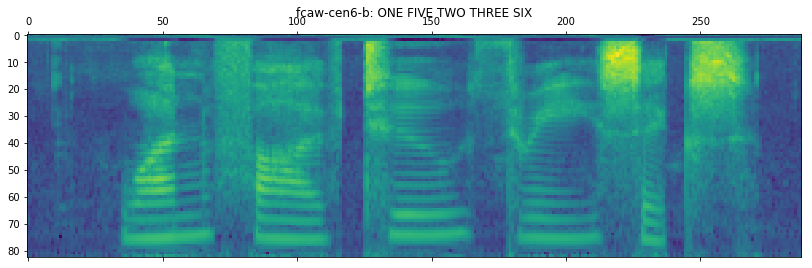

In [ ]:
import json
import matplotlib.pyplot as plt
import kaldiio

# load 10-th speech/text in data.json
root = "espnet/egs/an4/asr1"
with open(root + "/dump/test/deltafalse/data.json", "r") as f:
  test_json = json.load(f)["utts"]
  
key, info = list(test_json.items())[10]

# plot the speech feature
fbank = kaldiio.load_mat(info["input"][0]["feat"])
plt.matshow(fbank.T[::-1])
plt.title(key + ": " + info["output"][0]["text"])

# print the key-value pair
key, info

### Stage 3 - 4 NN Training

Let's go to the most interesting part...

In [ ]:
!tail espnet/egs/an4/asr1/conf/train_mtlalpha1.0.yaml

dlayers: 1
dunits: 300
# attention related
atype: location
adim: 320
aconv-chans: 10
aconv-filts: 100

# hybrid CTC/attention
mtlalpha: 1.0


In [ ]:
!cd espnet/egs/an4/asr1; ./run.sh  --ngpu 1 --stage 3 --stop-stage 4 --train-config ./conf/train_mtlalpha1.0.yaml

dictionary: data/lang_1char/train_nodev_units.txt
stage 3: LM Preparation
stage 4: Network Training


### TIPS: change_yaml.py

You can tweak YAML config by **$(change_yaml.py xxx.yaml -a yyy=zzz)**

In [ ]:
!cd espnet/egs/an4/asr1; source path.sh; \
  ./run.sh  --ngpu 1 --stage 4 --stop-stage 4 \
  --train-config $(change_yaml.py ./conf/train_mtlalpha1.0.yaml -a eunits=100)

dictionary: data/lang_1char/train_nodev_units.txt
stage 4: Network Training


### TIPS: tensorboard

You can easily monitor effects of the config by tensorboard

### Decoding and evaluation

decode config (`change_yaml.py` also works)

In [ ]:
!cat espnet/egs/an4/asr1/conf/decode_ctcweight1.0.yaml

# decoding parameter
beam-size: 20
penalty: 0.0
maxlenratio: 0.0
minlenratio: 0.0
ctc-weight: 1.0
lm-weight: 1.0


#### Command line usage

In [ ]:
!cd espnet/egs/an4/asr1; ./run.sh  --stage 5

dictionary: data/lang_1char/train_nodev_units.txt
stage 5: Decoding
2019-07-28 13:26:38,528 (splitjson:40) INFO: /usr/bin/python3 /content/espnet/egs/an4/asr1/../../../utils/splitjson.py --parts 8 dump/train_dev/deltafalse/data.json
2019-07-28 13:26:38,530 (splitjson:52) INFO: number of utterances = 100
2019-07-28 13:26:38,588 (splitjson:40) INFO: /usr/bin/python3 /content/espnet/egs/an4/asr1/../../../utils/splitjson.py --parts 8 dump/test/deltafalse/data.json
2019-07-28 13:26:38,590 (splitjson:52) INFO: number of utterances = 130
2019-07-28 13:37:48,300 (concatjson:36) INFO: /usr/bin/python3 /content/espnet/egs/an4/asr1/../../../utils/concatjson.py exp/train_nodev_pytorch_train_mtlalpha1.0/decode_train_dev_decode_ctcweight1.0_lm_word100/data.1.json exp/train_nodev_pytorch_train_mtlalpha1.0/decode_train_dev_decode_ctcweight1.0_lm_word100/data.2.json exp/train_nodev_pytorch_train_mtlalpha1.0/decode_train_dev_decode_ctcweight1.0_lm_word100/data.3.json exp/train_nodev_pytorch_train_mtlalp

#### ASR result as `data.json`

In [ ]:
!head -n20 espnet/egs/an4/asr1/exp/train_nodev_pytorch_train_mtlalpha1.0/decode_test_decode_ctcweight1.0_lm_word100/data.json

{
    "utts": {
        "fcaw-an406-b": {
            "output": [
                {
                    "name": "target1[1]",
                    "rec_text": "<blank><blank><blank>RUBOU<blank>T<blank><blank><blank> T N E F THREE NINE<eos>",
                    "rec_token": "<blank> <blank> <blank> R U B O U <blank> T <blank> <blank> <blank> <space> T <space> N <space> E <space> F <space> T H R E E <space> N I N E <eos>",
                    "rec_tokenid": "0 0 0 20 23 4 17 23 0 22 0 0 0 2 22 2 16 2 7 2 8 2 22 10 20 7 7 2 16 11 16 7 29",
                    "score": -1.0287089347839355,
                    "shape": [
                        25,
                        30
                    ],
                    "text": "RUBOUT G M E F THREE NINE",
                    "token": "R U B O U T <space> G <space> M <space> E <space> F <space> T H R E E <space> N I N E",
                    "tokenid": "20 23 4 17 23 22 2 9 2 15 2 7 2 8 2 22 10 20 7 7 2 16 11 16 7"
                }
          

### Recognize speech from python

Let's use  ESPnet as a library and the trained model:

In [ ]:
!ls espnet/egs/an4/asr1/exp/train_nodev_pytorch_train_mtlalpha1.0/results

cer.png		 snapshot.ep.1	 snapshot.ep.14  snapshot.ep.19  snapshot.ep.5
log		 snapshot.ep.10  snapshot.ep.15  snapshot.ep.2	 snapshot.ep.6
loss.png	 snapshot.ep.11  snapshot.ep.16  snapshot.ep.20  snapshot.ep.7
model.json	 snapshot.ep.12  snapshot.ep.17  snapshot.ep.3	 snapshot.ep.8
model.loss.best  snapshot.ep.13  snapshot.ep.18  snapshot.ep.4	 snapshot.ep.9


#### recap: load speech from data.json

Text(0.5, 1.05, 'fcaw-cen6-b: ONE FIVE TWO THREE SIX')

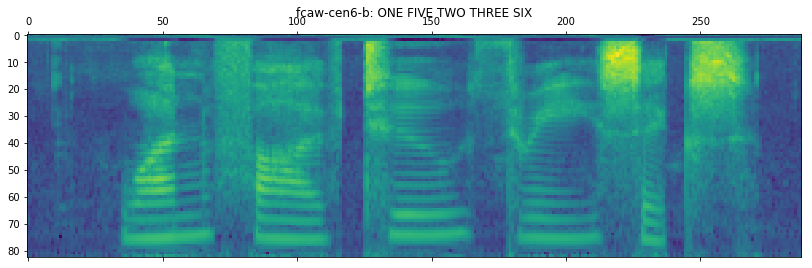

In [ ]:
import json
import matplotlib.pyplot as plt
import kaldiio

# load 10-th speech/text in data.json
root = "espnet/egs/an4/asr1"
with open(root + "/dump/test/deltafalse/data.json", "r") as f:
  test_json = json.load(f)["utts"]
  
key, info = list(test_json.items())[10]

# plot the speech feature
fbank = kaldiio.load_mat(info["input"][0]["feat"])
plt.matshow(fbank.T[::-1])
plt.title(key + ": " + info["output"][0]["text"])

#### load model

In [ ]:
import json
import torch
import argparse
from espnet.bin.asr_recog import get_parser
from espnet.nets.pytorch_backend.e2e_asr import E2E

root = "espnet/egs/an4/asr1"
model_dir = root + "/exp/train_nodev_pytorch_train_mtlalpha1.0/results"

# load model
with open(model_dir + "/model.json", "r") as f:
  idim, odim, conf = json.load(f)
model = E2E(idim, odim, argparse.Namespace(**conf))
model.load_state_dict(torch.load(model_dir + "/model.loss.best"))
model.cpu().eval()

# load token dict
with open(root + "/data/lang_1char/train_nodev_units.txt", "r") as f:
  token_list = [entry.split()[0] for entry in f]
token_list.insert(0, '<blank>')
token_list.append('<eos>')

# recognize speech
parser = get_parser()
args = parser.parse_args(["--beam-size", "2", "--ctc-weight", "1.0", "--result-label", "out.json", "--model", ""])
result = model.recognize(fbank, args, token_list)
s = "".join(conf["char_list"][y] for y in result[0]["yseq"]).replace("<eos>", "").replace("<space>", " ").replace("<blank>", "")

print("groundtruth:", info["output"][0]["text"])
print("prediction: ", s)

groundtruth: ONE FIVE TWO THREE SIX
prediction:  ONE FIVE TWO THREY SIX


In [ ]:
import os
import kaldiio
from IPython.display import Audio


try:
  d = os.getcwd()
  os.chdir(root)
  sr, wav = kaldiio.load_scp("data/test/wav.scp")[key]
finally:
  os.chdir(d)
Audio(wav, rate=sr)